In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def run_query(sql):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(sql,conn)

    
## create a function to run SQL queries that don't return tables
def run_command():
    with sqlite3.connect('chnook.db') as conn:
        conn.isolation_level=None
        conn.execute(c)

        
def show_tables():
    sql='SELECT name, type FROM sqlite_master WHERE type IN ("table","view");'
    return run_query(sql)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


_____
## Top genres in USA

In [3]:
###Which genres sell the most tracks in the USA
q1='''
WITH USA AS
    (SELECT il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id=il.invoice_id
     INNER JOIN customer c ON c.customer_id=i.customer_id
     WHERE c.country='USA'    
    )



SELECT g.name name,
        COUNT(USA.invoice_line_id) tracks_sold,
        CAST(COUNT(USA.invoice_line_id) AS FLOAT)/(SELECT COUNT(*) FROM USA) percentage_sold
FROM USA
INNER JOIN track t ON t.track_id=USA.track_id
INNER JOIN genre g ON t.genre_id=g.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

In [4]:
run_query(q1)

,name,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


In [5]:
genre_sales_usa=run_query(q1)

In [6]:
genre_sales_usa.set_index('name',inplace=True,drop=True)

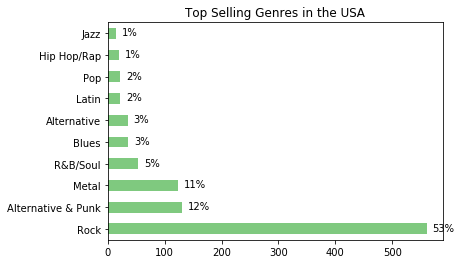

In [7]:
genre_sales_usa['tracks_sold'].plot.barh(title='Top Selling Genres in the USA',
                                        colormap=plt.cm.Accent)
plt.ylabel('')
for i, label in enumerate(list(genre_sales_usa.index)):
    score=genre_sales_usa.loc[label,'tracks_sold']
    label=(genre_sales_usa.loc[label,'percentage_sold']*100).astype(int).astype(str)+'%'
    plt.annotate(str(label),(score+10,i-0.1))

In [8]:
###Top Rock Artists and Albums
q2='''
WITH USA AS
    (SELECT il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id=il.invoice_id
     INNER JOIN customer c ON c.customer_id=i.customer_id
     WHERE c.country='USA'    
    )



SELECT ar.name artist,
        al.title album,
        COUNT(ar.name) total,
        g.name genre
FROM USA
INNER JOIN track t ON t.track_id=USA.track_id
INNER JOIN genre g ON t.genre_id=g.genre_id
INNER JOIN album al ON al.album_id=t.album_id
INNER JOIN artist ar ON ar.artist_id=al.artist_id
GROUP BY 1,2
HAVING genre='Rock'
ORDER BY total DESC
LIMIT 10;
'''

In [9]:
run_query(q2)

,artist,album,total,genre
0,Jimi Hendrix,Are You Experienced?,28,Rock
1,Nirvana,From The Muddy Banks Of The Wishkah [live],28,Rock
2,The Doors,The Doors,27,Rock
3,The Rolling Stones,"Hot Rocks, 1964-1971 (Disc 1)",25,Rock
4,Guns N' Roses,Use Your Illusion I,23,Rock
5,Alice In Chains,Facelift,21,Rock
6,Scorpions,20th Century Masters - The Millennium Collecti...,21,Rock
7,Van Halen,"The Best Of Van Halen, Vol. I",21,Rock
8,Pearl Jam,Live On Two Legs [live],19,Rock
9,AC/DC,For Those About To Rock We Salute You,16,Rock


Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:
* Jimi Hendrix - Are you Experienced?
* Nirvana From The Muddy Banks Of The Wishkah[live]
____

## Employee Sales Perfomance

In [10]:
q3='''
WITH customer_total AS 
    (SELECT i.customer_id,
            c.support_rep_id,
            SUM(i.total) total
    FROM invoice i
    INNER JOIN customer c ON c.customer_id=i.customer_id
    GROUP BY 1,2   
    )
    
SELECT e.first_name || " " || e.last_name name,
        SUM(ct.total) total
FROM customer_total ct
INNER JOIN employee e ON ct.support_rep_id=e.employee_id
GROUP BY 1
ORDER BY total DESC;
'''

In [11]:
run_query(q3)

,name,total
0,Jane Peacock,1731.51
1,Margaret Park,1584.00
2,Steve Johnson,1393.92


In [12]:
employee_sales=run_query(q3)

In [13]:
employee_sales.set_index('name',inplace=True)

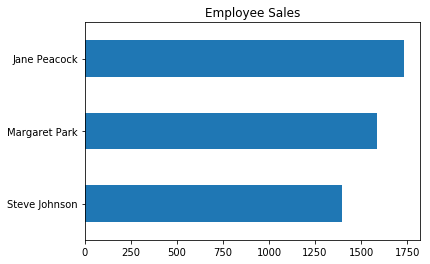

In [14]:
employee_sales.sort_values('total').plot.barh(title='Employee Sales',
                                              legend=False
                                             )
plt.ylabel('')

## Analyzing Sales by Country

In [15]:
q4='''
WITH country_or_other AS
(
SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
)


SELECT  country, 
        COUNT(DISTINCT(customer_id)) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price)/COUNT(DISTINCT(customer_id)) customer_lifetime_value,
        SUM(unit_price)/COUNT(DISTINCT(invoice_id)) average_order,
        CASE
            WHEN country='Other' THEN 1
            ELSE 0
        END AS sort
FROM country_or_other
GROUP BY 1
ORDER BY sort ASC, total_sales DESC;
'''

In [16]:
run_query(q4)

,country,customers,total_sales,customer_lifetime_value,average_order,sort
0,USA,13,1040.49,80.037692,7.942672,0
1,Canada,8,535.59,66.948750,7.047237,0
2,Brazil,5,427.68,85.536000,7.011148,0
3,France,5,389.07,77.814000,7.781400,0
4,Germany,4,334.62,83.655000,8.161463,0
5,Czech Republic,2,273.24,136.620000,9.108000,0
6,United Kingdom,3,245.52,81.840000,8.768571,0
7,Portugal,2,185.13,92.565000,6.383793,0
8,India,2,183.15,91.575000,8.721429,0
9,Other,15,1094.94,72.996000,7.448571,1


## Visualizing Sales by Country

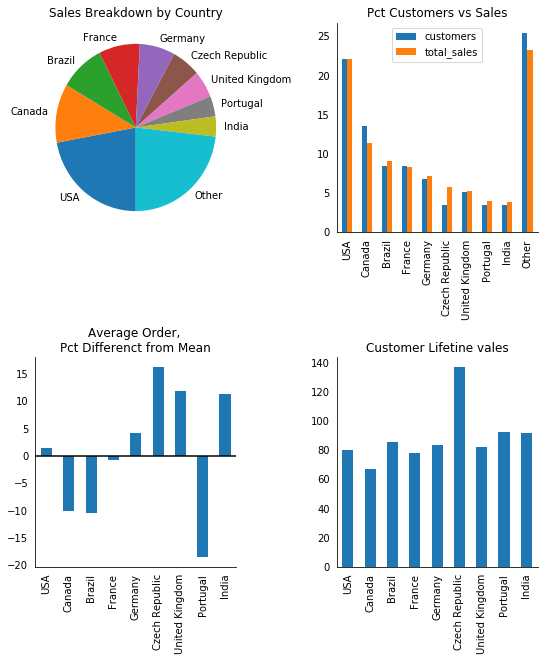

In [17]:
country_metrics=run_query(q4)
country_metrics.set_index('country',drop=True, inplace=True)

fig,axes=plt.subplots(2,2,figsize=(9,10))
ax1,ax2,ax3,ax4=axes.flatten()
fig.subplots_adjust(hspace=.6,wspace=.5)

#top left
sales_breakdown=country_metrics['total_sales'].copy().rename('')
sales_breakdown.plot.pie(
            ax=ax1,
            startangle=-90,
            counterclock=False,
            title='Sales Breakdown by Country'
)


#top right
customers_vs_dollars=country_metrics[['customers','total_sales']].copy()
customers_vs_dollars.index.name=''
for c in ['customers','total_sales']:
    customers_vs_dollars[c]/=customers_vs_dollars[c].sum()/100
customers_vs_dollars.plot.bar(
        ax=ax2,
        title='Pct Customers vs Sales'
)
ax2.tick_params(top='off',bottom='off',left='off',right='off')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)



#bottom left
avg_order=country_metrics['average_order'].copy()
avg_order.index.name=''
difference_from_avg=avg_order*100/avg_order.mean()-100
difference_from_avg.drop('Other',inplace=True)
difference_from_avg.plot.bar(
        ax=ax3,
        title="Average Order, \nPct Differenct from Mean"
)
ax3.tick_params(top='off',bottom='off',left='off',right='off')
ax3.axhline(0,color='k')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)



#bottom right
lifetime_value=country_metrics['customer_lifetime_value'].copy()
lifetime_value.index.name=''
lifetime_value.drop('Other',inplace=True)
lifetime_value.plot.bar(
        ax=ax4,
        title='Customer Lifetine vales'
)
ax4.tick_params(top='off',bottom='off',left='off',right='off')
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)


Based on the data, there may be opportunity in the following countries:
* Czech Republic
* United Kingdom
* India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

## Albums vs Individual Tracks

In [18]:
q5='''
WITH invoice_first_track AS
    (
    SELECT
            il.invoice_id invoice_id,
            MIN(il.track_id) first_track_id
    FROM invoice_line il
    GROUP BY 1
    )
    
SELECT
    album_purchase,
    COUNT(invoice_id) numer_of_invoices,
    CAST(count(invoice_id) AS FLOAT)/(SELECT COUNT(*) FROM invoice) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                (
                SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     )
                ) IS NULL
        THEN 'yes'
        ELSE 'no'
    END AS 'album_purchase'
    FROM invoice_first_track ifs
    )
GROUP BY 1;
'''

In [19]:
run_query(q5)

,album_purchase,numer_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.